### Compare model output with a grided data (precipitation)

### Datasets for spatial precipitation

1. NetCDFs NCEP Stage IV QPE data

    - Last 24 hours of QPE spanning 12Z to 12Z in inches
    - website: https://water.noaa.gov/about/precipitation-data-access
    - download: https://water.noaa.gov/resources/downloads/precip/stageIV/

2. NetCDFs PRISM 4 km 

    - Last 24 hours interpolated from stations, spanning 12Z to 12Z in inches
    - website: https://www.prism.oregonstate.edu/
    - download: https://prism.oregonstate.edu/documents/PRISM_downloads_web_service.pdf (see pg. 4)

In [1]:
# libs
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import xarray as xr
import glob
import os
import numpy as np
import pandas as pd
from pyproj import CRS, Transformer

In [2]:
# set paths
qpe_path = '/glade/u/home/jhenao/atm746/data_precip/ncep_qpe/'
wrf_path = '/glade/derecho/scratch/jhenao/atm746/ar_mp9_bl2/'
psm_path = '/glade/u/home/jhenao/atm746/data_precip/prism_4km/'


wrf_files = sorted(glob.glob(wrf_path+"wrfout_d02*"))
qpe_files = sorted(glob.glob(qpe_path+"nws_precip*conus.nc"))
psm_files = sorted(glob.glob(psm_path+"prism_ppt_us_25m_*.nc"))

ds_mf_qp = xr.open_mfdataset(qpe_files,combine='nested', concat_dim='time')
ds_mf_wf = xr.open_mfdataset(wrf_files, combine='nested', concat_dim='Time')
ds_mf_pm = xr.open_mfdataset(psm_files,combine='nested', concat_dim='time')

In [3]:
ds_mf_qp.time

<xarray.DataArray 'time' (time: 6)> Size: 48B
array(['2024-11-19T00:00:00.000000000', '2024-11-20T00:00:00.000000000',
       '2024-11-21T00:00:00.000000000', '2024-11-22T00:00:00.000000000',
       '2024-11-23T00:00:00.000000000', '2024-11-24T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 48B 2024-11-19 2024-11-20 ... 2024-11-24
Attributes:
    long_name:      The date of precipitation accumulation data which this ne...
    standard_name:  time
    axis:           T

In [4]:
ds_mf_qp.observation

<xarray.DataArray 'observation' (time: 6, y: 881, x: 1121)> Size: 24MB
dask.array<concatenate, shape=(6, 881, 1121), dtype=float32, chunksize=(1, 881, 1121), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 48B 2024-11-19 2024-11-20 ... 2024-11-24
  * x        (x) float64 9kB -1.903e+06 -1.898e+06 ... 3.427e+06 3.431e+06
  * y        (y) float64 7kB -3.426e+06 -3.431e+06 ... -7.612e+06 -7.617e+06
Attributes:
    proj4:           +proj=stere +lat_0=90 +lat_ts=60 +lon_0=-105 +x_0=0 +y_0...
    grid_mapping:    crs
    name:            observation
    long_name:       Observation
    units:           Inches
    esri_pe_string:  PROJCS["NOAA_HRAP_Grid",    GEOGCS["GCS_NOAA_HRAP",     ...

In [5]:
crs_str = ds_mf_qp['crs'].attrs['proj4']

In [6]:
crs_proj = CRS.from_proj4(crs_str)
crs_latlon = CRS.from_epsg(4326)  # WGS84
transformer = Transformer.from_crs(crs_proj, crs_latlon, always_xy=True)

In [7]:
# Extract x and y arrays
x = ds_mf_qp['x'].values  # shape (nx,)
y = ds_mf_qp['y'].values  # shape (ny,)

# Create 2D grids
X, Y = np.meshgrid(x, y)  # shape (ny, nx)
lon, lat = transformer.transform(X, Y)  # both are (ny, nx)
# Let's say your main variable is ds['observation']

ds_mf_qp = ds_mf_qp.assign_coords({
    'latitude': (('y', 'x'), lat),
    'longitude': (('y', 'x'), lon)
})


In [8]:
# special value of -10,000 indicates the cell is expected to
# have valid data, however, no data has been received
rain_clean = ds_mf_qp.observation.where(ds_mf_qp.observation != -10000, np.nan)

In [9]:
# sum them all 
total_qp = rain_clean.sum(dim='time')

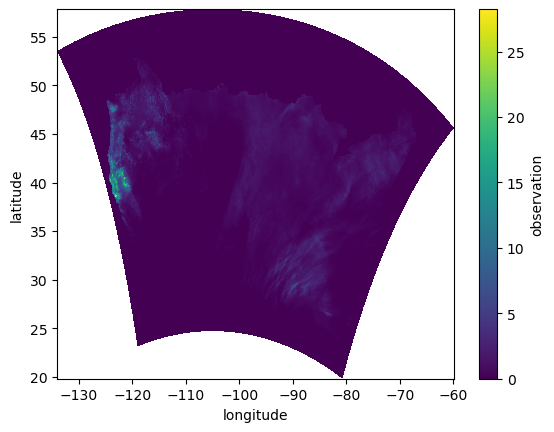

In [10]:
# plot
total_qp.plot(x='longitude',y='latitude')

In [11]:
lat_qp = total_qp['latitude']
lon_qp = total_qp['longitude']

# convert from in to mm
in2mm = 25.4

total_qp_mm = total_qp.values * in2mm

In [12]:
# wrf rain
total_wf = ds_mf_wf.RAINNC[-1,:] + ds_mf_wf.RAINC[-1,:]

lat_wf = ds_mf_wf.XLAT[-1,:]
lon_wf = ds_mf_wf.XLONG[-1,:]

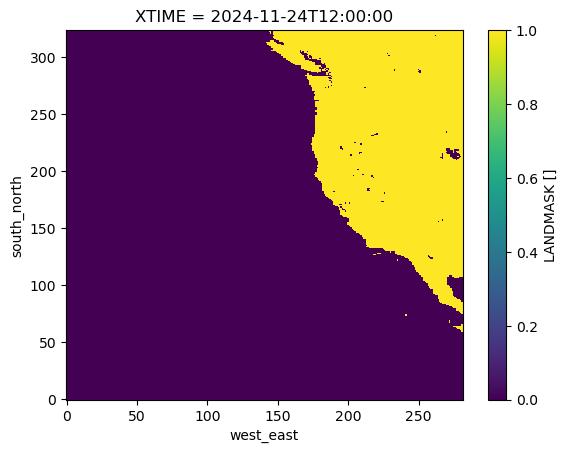

In [13]:
ds_mf_wf.LANDMASK[-1].plot()
landmask=ds_mf_wf.LANDMASK[-1]

In [14]:
total_wf_land = total_wf.where(landmask == 1)

In [15]:
lat_pm = ds_mf_pm.lat
lon_pm = ds_mf_pm.lon

total_pm = ds_mf_pm.Band1.sum(dim='time')

In [16]:
#create a color map

# colormap creation
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

clrs = [
    "#FAFAFA", 
    "#94A494", 
    "#02C702", 
    "#017301", 
    "#117901", 
    "#C6C002", 
    "#C7C402", 
    "#B59400", 
    "#B88F00", 
    "#C77100", 
    "#C70000", 
    "#960000", 
    "#990010", 
    "#BC00A5", 
    "#C400C7", 
    "#8739A8", 
    "#7A45A1", 
]
cmap = LinearSegmentedColormap.from_list('div', clrs)
levs = np.arange(10,510,10)
levs_prec = np.insert(levs, 0, 0.001)
norm = mpl.colors.BoundaryNorm(levs_prec, cmap.N, clip=True)

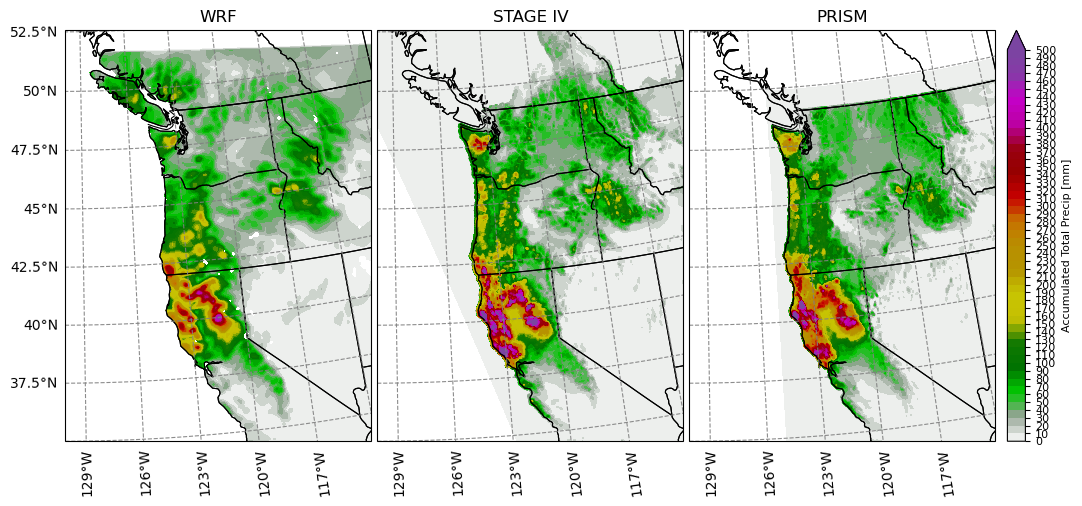

In [18]:


lon_min = -130
lon_max = -114
lat_min = 35
lat_max = lat_wf.max()


# a Lambert projection using ref lat and lon from namelist.wps
projection = ccrs.LambertConformal(central_longitude=-130.392, central_latitude=35.174)


fig, ax = plt.subplots(
    nrows=1, 
    ncols=3,
    subplot_kw={'projection': projection},
    figsize=(12, 8), 
    sharex=True, 
    sharey=True
)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.02, hspace=0.04)

ax = ax.flatten()

for i in range(len(ax)):
    ## bounding box limits
    ax[i].set_extent([lon_min, lon_max, lat_min, lat_max]) 
    # add coastline, states and borders
    ax[i].add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax[i].add_feature(cfeature.STATES, linewidth=0.8)
    ax[i].add_feature(cfeature.BORDERS, linewidth=0.8)
    #add grid
    grid = ax[i].gridlines(draw_labels=True, x_inline=False, y_inline=False,
                    color='gray', alpha=0.9, linestyle='--')
    grid.top_labels = False
    grid.right_labels = False
    if i > 0:
        grid.left_labels = False

## WRF
# add contour lines
p0 = ax[0].contourf(
    lon_wf, lat_wf, total_wf_land,
    levels=levs_prec,
    cmap=cmap,
    extend='max',
    transform=ccrs.PlateCarree()
)

p1 = ax[1].contourf(
    lon_qp, lat_qp, total_qp_mm,
    levels=levs_prec,
    cmap=cmap,
    extend='max',
    transform=ccrs.PlateCarree()
)

p2 = ax[2].contourf(
    lon_pm, lat_pm, total_pm,
    levels=levs_prec,
    cmap=cmap,
    extend='max',
    transform=ccrs.PlateCarree()
)

ax[0].set_title("WRF")
ax[1].set_title("STAGE IV")
ax[2].set_title("PRISM")


cax = fig.add_axes([ax[2].get_position().x1 + 0.01,ax[2].get_position().y0,0.015,ax[2].get_position().height])
cbar=plt.colorbar(p2, pad=0.005,ticks=levs_prec,cax=cax,orientation="vertical")
cbar.ax.tick_params(labelsize=8)
cbar.set_label('Accumulated Total Precip [mm]',fontsize=8)



plt.show()